## Домашнее задание №9
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [52]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [53]:
# do not change the code in the block below
# __________start of block__________
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cpu device is available


#### 1. Загрузка данных.

In [54]:
# do not change the code in the block below
# __________start of block__________
#!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [55]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [56]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [57]:
next(generate_chunk())

array([[83, 63, 50, ..., 63, 45, 57],
       [83,  1, 55, ..., 61, 45, 47],
       [83,  1, 56, ..., 59,  1, 56],
       ...,
       [83, 53,  1, ..., 50, 52,  1],
       [83, 57, 50, ..., 50, 69, 73],
       [83,  0, 33, ..., 59,  1, 56]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [58]:
# your beautiful experiments here

class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=18, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        #линейный слой
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
    def forward(self, x, h_prev):
        # get vector embedding of x
        x_emb = self.embedding(x)
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next) #функция активации
        assert h_next.size() == h_prev.size()
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) #еще один линейный слой
        return h_next, logits
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)


In [59]:
def rnn_loop(char_rnn, batch_ix):

    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logits = []
    for x_t in batch_ix.transpose(0,1):
        hid_state, logits_next = char_rnn(x_t, hid_state) # <-- here we call your one-step code
        logits.append(logits_next)
    return torch.stack(logits, dim=1)

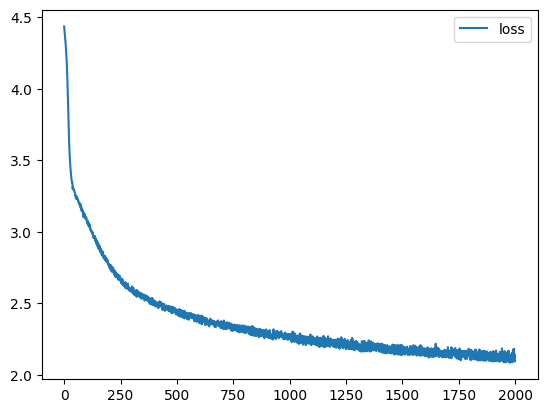

In [60]:
from IPython.display import clear_output
from random import sample
char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
loss_func = nn.CrossEntropyLoss()
history = []

MAX_LENGTH = 16
for i in range(2000):
    batch_ix = next(generate_chunk())
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    logits_seq = rnn_loop(char_rnn, batch_ix)
    # compute loss
    predictions_logits = logits_seq[:, :-1] #это и есть наши предсказания
    actual_next_tokens = batch_ix[:, 1:]
    loss = loss_func(
    predictions_logits.reshape((-1, num_tokens)),
        actual_next_tokens.reshape(-1)
    )
    loss.backward()
    opt.step()
    opt.zero_grad() #зануляем градиенты
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()
    #assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."


В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [67]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any

    # your code here

    hid_state = (char_rnn.initial_state(batch_size=1)).to(device)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits_next = char_rnn(x_sequence[:, -1], hid_state)
        hid_state = hid_state.to(device)
        logits_next = logits_next.to(device)
        p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0] #вероятность взять токен
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)

        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)



    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [68]:
print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилить пошелова сталовы,
к теперною совно,
которой
i
о старится, бедникал он нею приздце бесе, поделит тары пальша но устанный родит вечто примечто бузданце…
на сиренье
в еще там мою и лет ведвих сспанный всё на раздою
стрита льбовил
я много в ссегравенный сторо
бильских печит, была он сумой порамичакать все простароку,
никой взгорокаясь любовною с не ци ни желью, дутоли, и соболина сек придет, эне нему?
почилась жетний ней и мом и песельней…
ок
я любов…,
потаны.



xx


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [70]:
#generated_phrases = # your code here

# For example:

generated_phrases = [
    generate_sample(
        char_rnn,
        ' мой дядя самых честных правил',
          max_length=500,
          temperature=1.
      ).replace('<sos>', '')
      for _ in range(10)
  ]

In [71]:
# do not change the code in the block below
# __________start of block__________

if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')
# __________end of block__________

File saved to `submission_dict_hw07.npy`


На этом задание завершено. Поздравляем!